# Hammanskraal, Antenna Position Calibration

Author: Tim Molteno. tim@elec.ac.nz.

The antennas are laid out on five spiral arms.  This notebook will use measurements to infer the actual layout of the antennas.

The other reference point is the center of the array. This is assumed to be the point [0,0]. Make sure that a marker is present at this reference point at the same height as the level of the antennas (otherwise the distances will be wrong).

In [1]:
import numpy as np
from scipy.optimize import minimize 

In [2]:
site_name = 'za-hammanskraal'
x0 = [0,0]
global_rot_degrees = 0
global_rot_index = 3

In [3]:
import pandas as pd

cols = [f"A {i}" for i in range(24)]
data = pd.read_excel('antenna_measurements.ods', "Sheet1", usecols=cols)
radius = data.loc[0]
radius

A 0      350.0
A 1      914.0
A 2     1295.0
A 3     1545.0
A 4     1770.0
A 5      274.0
A 6      830.0
A 7     1324.0
A 8     1616.0
A 9     1776.0
A 10     230.0
A 11     898.0
A 12    1240.0
A 13    1535.0
A 14    1805.0
A 15     385.0
A 16     940.0
A 17    1295.0
A 18    1530.0
A 19    1786.0
A 20     365.0
A 21    1060.0
A 22    1440.0
A 23    1780.0
Name: 0, dtype: float64

## Finding the antennas

This is done by measuring the distance from each antenna to x0 as well as each other antenna. The distance $m_0$ are the measurements to $x_0$. The array m_ij are the distances between antennas.

In [4]:
n_ant = 24
m_0 = np.zeros(n_ant)
m_ij = np.zeros((n_ant,n_ant))

radius = data.loc[0]

for i in range(n_ant):
    m_ij[i,:] = data.loc[i+1]

The following are the measured distances from [x1, x0, x2] from the reference points in millimeters. Note that their order must be the same as the order of the variable called 'reference_points'. In this case, they are x1,x0,x2.

In [5]:
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            m_ij[j,i] = m_ij[i,j]

m_ij


array([[  nan,  594., 1020., 1335., 1645.,  379.,  874., 1456., 1845.,
        2050.,  558., 1235., 1597., 1883., 2113.,  712., 1182., 1467.,
        1623., 1743.,  419.,  880., 1144., 1411.],
       [ 594.,   nan,  500.,  915., 1355.,  797.,  998., 1616., 2113.,
        2385., 1080., 1725., 2130., 2467., 2700., 1302., 1765., 1988.,
        2065., 2075.,  973., 1081., 1034.,  987.],
       [1020.,  500.,   nan,  445.,  945., 1091., 1010., 1560., 2113.,
        2436., 1400., 1965., 2400., 2782., 3095., 1695., 2200., 2471.,
        2570., 2570., 1435., 1575., 1450., 1170.],
       [1335.,  915.,  445.,   nan,  519., 1290., 1001., 1396., 1960.,
        2308., 1574., 2026., 2470., 2915., 3298., 1935., 2477., 2797.,
        2941., 2987., 1754., 2000., 1899., 1589.],
       [1645., 1355.,  945.,  519.,   nan, 1493., 1035., 1190., 1725.,
        2097., 1740., 2046., 2484., 2955., 3415., 2135., 2694., 3070.,
        3279., 3375., 2050., 2414., 2375., 2095.],
       [ 379.,  797., 1091., 1290.,

## Plot the Initial Guess Points

Initial Guesses are from JSON queried from the telescope API. These are converted to millimeters.

In [6]:
import json
import requests

def get_data(path):
    server = "https://api.elec.ac.nz/tart/zm-cbu/"

    r = requests.get('{}/{}'.format(server, path))
    return json.loads(r.text)

def get_pos():
    return np.array(get_data('api/v1/imaging/antenna_positions'))

if False:
    with open('hammanskraal_antenna_positions_nonaligned.json', "r") as f:
        data = f.read()
    cal_json = json.loads(data)
    current_pos = cal_json["ant_pos"]
    current_pos = np.array(current_pos)
else:
    current_pos = get_pos()
    json_result = {}
    json_result["antenna_positions"] = current_pos.tolist()
    print(json.dumps(json_result, indent=4, separators=(',', ': ')))


{
    "antenna_positions": [
        [
            0.21265862175004066,
            0.2604866802647942,
            0.0
        ],
        [
            0.442807432858482,
            0.7031383771387258,
            0.0
        ],
        [
            0.4481033444122767,
            1.1179840753456787,
            0.0
        ],
        [
            0.31020764897177366,
            1.4372046529702736,
            0.0
        ],
        [
            0.07448585598314927,
            1.693218785998566,
            0.0
        ],
        [
            0.3129600074651546,
            -0.12479196179005407,
            0.0
        ],
        [
            0.801683059413253,
            -0.22134649816477026,
            0.0
        ],
        [
            1.2004714913484789,
            -0.11132474324946381,
            0.0
        ],
        [
            1.467309295024204,
            0.10894233674551676,
            0.0
        ],
        [
            1.6488618860604012,
            0.

212.65862175004065 260.4866802647942
442.807432858482 703.1383771387259
448.1033444122767 1117.9840753456788
310.20764897177366 1437.2046529702736
74.48585598314928 1693.2187859985659
312.9600074651546 -124.79196179005407
801.683059413253 -221.34649816477025
1200.4714913484788 -111.32474324946381
1467.309295024204 108.94233674551676
1648.8618860604013 408.8550852042031
-22.412636048796767 -336.6343323925
46.48706824215006 -829.704135512322
280.6133043466542 -1169.9171651974561
575.4282332190818 -1349.734176945359
916.781294405724 -1423.970876888908
-328.14316838272714 -82.28645723170465
-779.5138457969381 -297.2039101540683
-1033.918303280115 -620.9621100698239
-1116.4580552391578 -956.7420816978823
-1084.2119930238066 -1304.5310859398273
-182.471919176897 290.8487557338005
-520.133118426142 657.6796629943008
-905.4088936774308 805.7187693294793
-1252.7226279470508 783.5113384179166


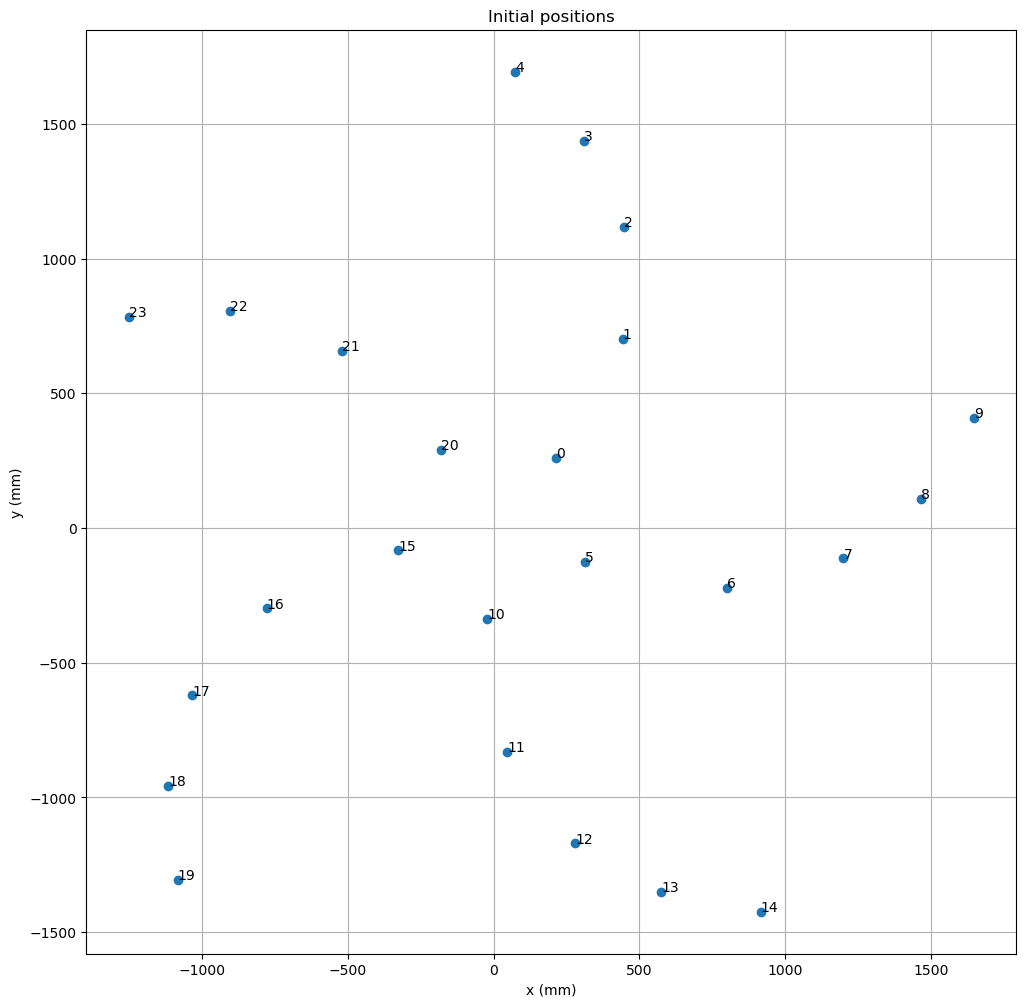

In [7]:
def i_y(i):
    return 2*i+1

def i_x(i):
    return 2*i


initial_guess = np.zeros(2*n_ant)

for i in range(n_ant):
    x,y = current_pos[i][0:2]*1000
    initial_guess[i_x(i)] = x
    initial_guess[i_y(i)] = y
    
    print(x,y)
initial_guess

pos_i = current_pos*1000
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1])
for i in range(0,pos_i.shape[0]):
    ax.text(pos_i[i,0], pos_i[i,1],f"{i}")

ax.grid(True)
ax.set_title('Initial positions')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.savefig('initial_positions.png')
plt.show()

## Criteria for Optimality

The function below is minimized when the positions (in variable x) are consistent with the measured distances m[i,j]. The initial value of this function is more than 3 million.

Note that the x input is a 1D vector of with 48 entries as [p0.x, p0.y, p1.x, p1.y]

In [8]:
def geo_angle(x,y):
    return 90 - np.degrees(np.arctan2(y,x))

geo_angle(1,0)

np.float64(90.0)

In [9]:
def dist(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)


def p(x, i):
    return [x[i_x(i)],x[i_y(i)]]

max_err = 4200
def bounds():
    ret = [(0,0)]*48
    for i in range(n_ant):
        _x,_y = pos_i[i,0], pos_i[i,1]
        ret[i_x(i)] = (_x - max_err, _x + max_err)
        ret[i_y(i)] = (_y - max_err, _y + max_err)
    
    return ret

bnd = bounds()

center = [0,0]

def angle(x, i):
    _x, _y = p(x, i)
    return geo_angle(_x, _y)
    
def radius_model(x):
    ret = []
    
    for i in range(n_ant):
        p_i = p(x,i)
        ret.append(dist(center, p_i))
        
    return np.array(ret)

non_nan_ij = []
non_nan_indices = []
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            non_nan_ij.append(m_ij[i,j])
            non_nan_indices.append([i,j])
non_nan_ij = np.array(non_nan_ij)
non_nan_indices = np.array(non_nan_indices)

def m_ij_model(x):
    ret = []
    for i in range(n_ant):
        p_i = p(x,i)

        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret.append(dist(p_j, p_i))
                
    return np.array(ret)
    
def radius_residual(x):
    predict = radius_model(x)
    return predict - radius

def m_ij_residual(x):
    predict = m_ij_model(x)
    return predict - non_nan_ij

def rot_residual(x):
    predict = angle(x, global_rot_index)
    return predict - global_rot_degrees

def f_old(x):
    ret = 0
    for i in range(n_ant):
        p_i = p(x,i)
        ret += (dist(center, p_i) - m_0[i])**2
        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret += (dist(p_j, p_i) - m_ij[i,j])**2
    return ret

def f(x):
    # This is the final criterion for optimality. The sum of squared residuals.
    ret = np.sum(radius_residual(x)**2)
    ret += np.sum(m_ij_residual(x)**2)
    ret += rot_residual(x)**2
    return ret


In [10]:
print(f(initial_guess))

99642645.56164356


 We can see that the initial value of this optimality condition is about 50 million.

In [11]:
res = minimize(f, initial_guess, bounds=None, options={'maxiter': 100})
res

  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 12084.915175926373
        x: [-2.240e+02  2.754e+02 ... -1.305e+03  1.180e+03]
      nit: 100
      jac: [-7.882e-01  9.650e-01 ... -3.142e+00  3.027e+00]
 hess_inv: [[ 7.820e-01  5.838e-01 ...  3.133e+00  3.390e+00]
            [ 5.838e-01  5.293e-01 ...  2.503e+00  2.781e+00]
            ...
            [ 3.133e+00  2.503e+00 ...  1.338e+01  1.459e+01]
            [ 3.390e+00  2.781e+00 ...  1.459e+01  1.604e+01]]
     nfev: 6615
     njev: 135

In [12]:
err = res.jac.reshape((24,2))
rms = err # np.sqrt(np.sum(err**2, axis=1))
for i in range(24):
    print(f"Ant {i}:\tJac: {rms[i,0]:06.2f}, \t{rms[i,1]:06.2f}")

Ant 0:	Jac: -00.79, 	000.96
Ant 1:	Jac: -01.32, 	002.47
Ant 2:	Jac: -00.58, 	003.66
Ant 3:	Jac: 000.76, 	003.58
Ant 4:	Jac: 001.94, 	004.13
Ant 5:	Jac: 000.46, 	000.77
Ant 6:	Jac: 001.59, 	001.87
Ant 7:	Jac: 003.01, 	001.45
Ant 8:	Jac: 003.84, 	000.18
Ant 9:	Jac: 004.10, 	-00.72
Ant 10:	Jac: 000.59, 	-00.15
Ant 11:	Jac: 002.31, 	-01.08
Ant 12:	Jac: 002.42, 	-02.27
Ant 13:	Jac: 001.61, 	-03.33
Ant 14:	Jac: 000.52, 	-04.44
Ant 15:	Jac: 000.00, 	-01.10
Ant 16:	Jac: -00.49, 	-02.48
Ant 17:	Jac: -01.82, 	-02.84
Ant 18:	Jac: -03.11, 	-02.74
Ant 19:	Jac: -04.22, 	-02.09
Ant 20:	Jac: -01.14, 	-00.24
Ant 21:	Jac: -02.95, 	-00.04
Ant 22:	Jac: -03.63, 	001.33
Ant 23:	Jac: -03.14, 	003.03


The optimized positions are now known. The final value of the function is 32. Far closer to zero than 3 million!

We can recover the x,y coordinates by reshaping the array

In [13]:
pos = res.x.reshape((24,2))
pos

array([[ -224.00928696,   275.36319274],
       [ -371.4028973 ,   847.43911712],
       [ -140.41915622,  1293.39126611],
       [  246.26928144,  1523.11614349],
       [  749.39302599,  1608.10319754],
       [  154.36824139,   242.22174665],
       [  592.81735909,   593.70929219],
       [ 1214.68729575,   517.97209332],
       [ 1615.06794238,   117.76697069],
       [ 1760.84799696,  -225.7783428 ],
       [  228.19409411,   -53.48621654],
       [  778.85120364,  -441.43057749],
       [  879.45990202,  -871.9668355 ],
       [  715.49543144, -1349.75782339],
       [  278.79122714, -1776.37732201],
       [   12.98752806,  -396.62836265],
       [ -214.40532132,  -911.10552543],
       [ -671.73551774, -1118.42153037],
       [-1136.41127106, -1073.82041663],
       [-1567.07353766,  -845.01491349],
       [ -342.78374917,  -126.80426949],
       [-1061.40217572,    12.39674575],
       [-1345.29703177,   491.44838771],
       [-1304.93516173,  1180.47521936]])

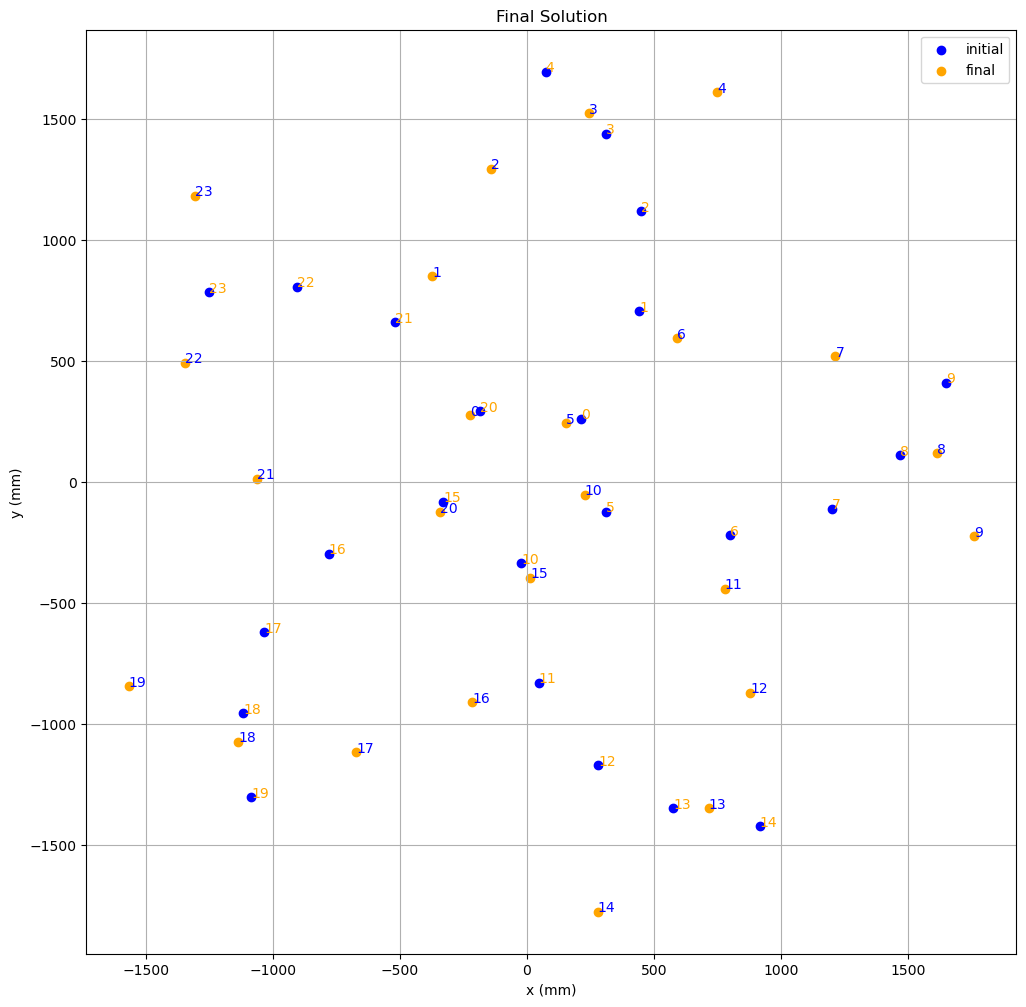

In [14]:
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1], label='initial', color='blue')
ax.scatter(pos[:,0], pos[:,1], label='final', color='orange')

for i in range(0,pos_i.shape[0]):
    ax.text(pos_i[i,0], pos_i[i,1],f"{i}", color='orange')

for i in range(0,pos.shape[0]):
    ax.text(pos[i,0], pos[i,1],f"{i}", color='blue')

ax.grid(True)
ax.set_title('Final Solution')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.legend()
plt.savefig('final_positions.png')
plt.show()

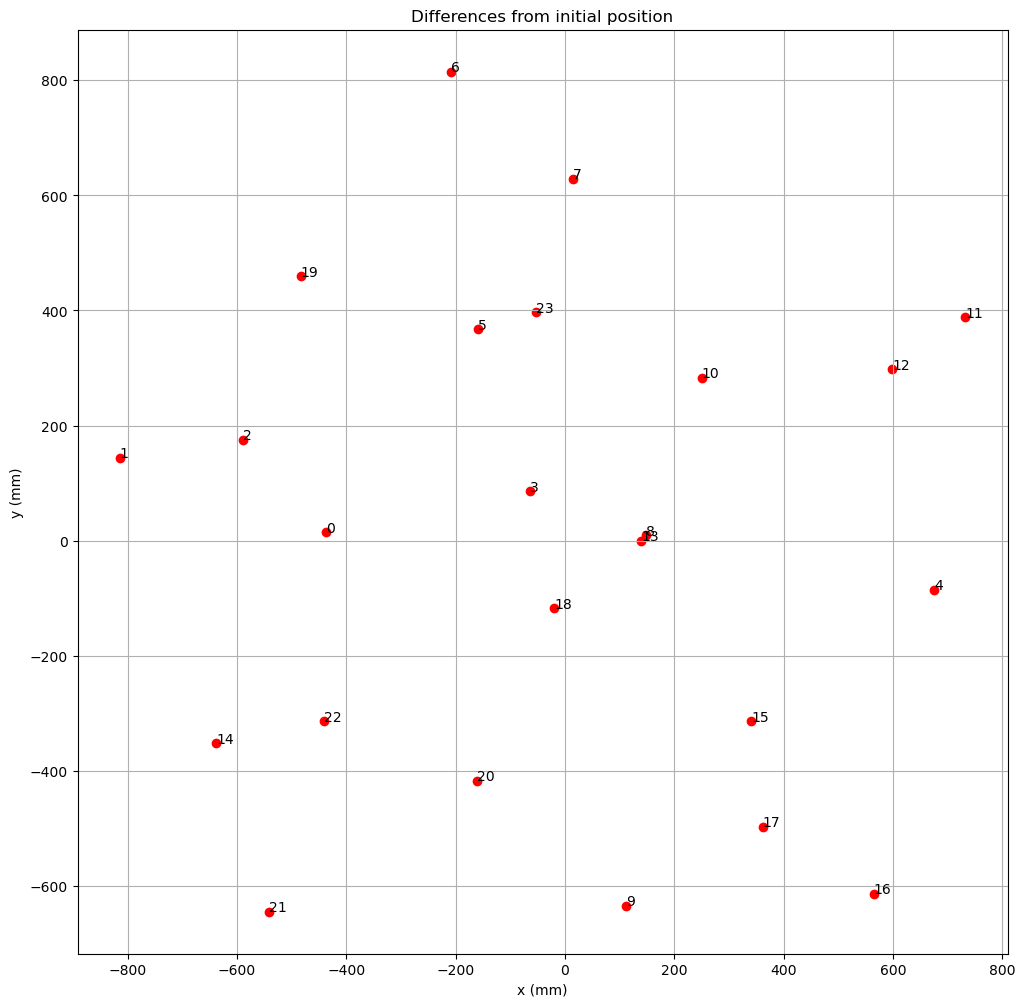

In [15]:
# Differences plot
diff = pos - pos_i[:,0:2]


fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(diff[:,0], diff[:,1], color='red')

for i in range(0,diff.shape[0]):
    ax.text(diff[i,0], diff[i,1],f"{i}")

ax.grid(True)
ax.set_title("Differences from initial position")
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.savefig('differences.png')
plt.show()

In [16]:
# Residual plot
rres = radius_residual(res.x)
rres

A 0      4.971898
A 1     11.253030
A 2      5.991355
A 3     -2.102937
A 4      4.143681
A 5     13.229749
A 6      9.001278
A 7     -3.484829
A 8      3.355896
A 9     -0.736209
A 10     4.378583
A 11    -2.751346
A 12    -1.542943
A 13    -7.328604
A 14    -6.878497
A 15    11.840943
A 16    -4.006987
A 17     9.643754
A 18    33.496359
A 19    -5.615301
A 20     0.486007
A 21     1.474568
A 22    -7.748059
A 23   -20.347330
Name: 0, dtype: float64

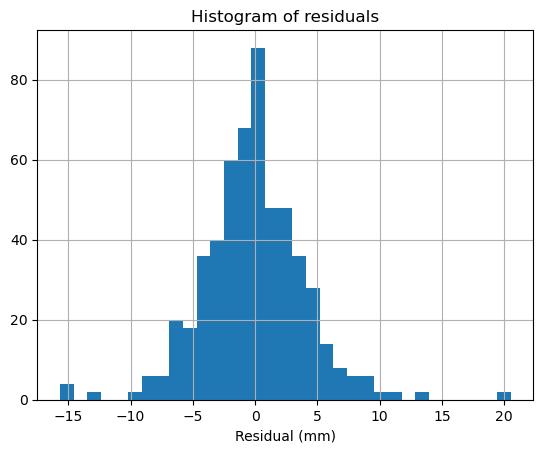

In [17]:
# ij resdual
ijres = m_ij_residual(res.x)
plt.hist(ijres, bins='fd');
plt.title("Histogram of residuals")
plt.xlabel("Residual (mm)")
plt.grid(True)
plt.savefig("residual_histogram.png")

The API expects 3D coordinates (with a z value which is zero in this case). Therefore we add a column of zeros.

In [18]:
absres = np.abs(ijres)
p95 = np.percentile(absres, 95)

print(f"95th percentile of residuals is {p95:4.2f} mm")
ijres_matrix = np.zeros_like(m_ij)
for r, i, j in zip(ijres, non_nan_indices[:,0], non_nan_indices[:,1]):
    if np.abs(r) > p95 and i > j:
        print(f" res[{i},{j}] = {r:3.1f}")
    ijres_matrix[i,j] = r
    


95th percentile of residuals is 8.44 mm
 res[4,3] = -8.7
 res[6,3] = -9.1
 res[6,4] = -8.6
 res[9,5] = -9.7
 res[11,3] = 9.5
 res[11,5] = 10.9
 res[12,11] = 10.1
 res[13,1] = -15.7
 res[13,11] = 20.5
 res[14,5] = -12.6
 res[22,12] = 9.3
 res[22,13] = 8.5
 res[23,5] = -15.1
 res[23,13] = 13.9


## Output best estimates

Write some json files...

In [19]:
result = np.zeros((n_ant, 3))
result[:,:-1] = np.round(pos/1000.0, 3)
result

array([[-0.224,  0.275,  0.   ],
       [-0.371,  0.847,  0.   ],
       [-0.14 ,  1.293,  0.   ],
       [ 0.246,  1.523,  0.   ],
       [ 0.749,  1.608,  0.   ],
       [ 0.154,  0.242,  0.   ],
       [ 0.593,  0.594,  0.   ],
       [ 1.215,  0.518,  0.   ],
       [ 1.615,  0.118,  0.   ],
       [ 1.761, -0.226,  0.   ],
       [ 0.228, -0.053,  0.   ],
       [ 0.779, -0.441,  0.   ],
       [ 0.879, -0.872,  0.   ],
       [ 0.715, -1.35 ,  0.   ],
       [ 0.279, -1.776,  0.   ],
       [ 0.013, -0.397,  0.   ],
       [-0.214, -0.911,  0.   ],
       [-0.672, -1.118,  0.   ],
       [-1.136, -1.074,  0.   ],
       [-1.567, -0.845,  0.   ],
       [-0.343, -0.127,  0.   ],
       [-1.061,  0.012,  0.   ],
       [-1.345,  0.491,  0.   ],
       [-1.305,  1.18 ,  0.   ]])

In [20]:
json_result = {}
json_result["antenna_positions"] = result.tolist()

f = open("hammanskraal_processed_antenna_positions.json", "w")
f.write(json.dumps(json_result))
f.close()

pos_json = json.dumps(json_result, indent=4, separators=(',', ': '))
print(pos_json)

{
    "antenna_positions": [
        [
            -0.224,
            0.275,
            0.0
        ],
        [
            -0.371,
            0.847,
            0.0
        ],
        [
            -0.14,
            1.293,
            0.0
        ],
        [
            0.246,
            1.523,
            0.0
        ],
        [
            0.749,
            1.608,
            0.0
        ],
        [
            0.154,
            0.242,
            0.0
        ],
        [
            0.593,
            0.594,
            0.0
        ],
        [
            1.215,
            0.518,
            0.0
        ],
        [
            1.615,
            0.118,
            0.0
        ],
        [
            1.761,
            -0.226,
            0.0
        ],
        [
            0.228,
            -0.053,
            0.0
        ],
        [
            0.779,
            -0.441,
            0.0
        ],
        [
            0.879,
            -0.872,
            0.0
 

The position file above is in a format suitable for uploading to the telescope api. Also for using as the calibrated_antenna_positions.json file in TART/software/containers/telescope_web_api/config_data.


    tart_upload_antenna_positions --api https://api.elec.ac.nz/tart/zm-cbu --pw=xxxx --file cbu_processed_antenna_positions.json
